# Capstone Design
---
### 2021 COSE489

화폐 분류 모델 생성   
2018320156 박노경

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir = '/content/drive/Shareddrives/캡스톤디자인/data/'
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2147


In [5]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/Shareddrives/\xe1\x84\x8f\xe1\x85\xa2\xe1\x86\xb8\xe1\x84\x89\xe1\x85\xb3\xe1\x84\x90\xe1\x85\xa9\xe1\x86\xab\xe1\x84\x83\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xa1\xe1\x84\x8b\xe1\x85\xb5\xe1\x86\xab/data/10won/10-21-rotate180.jpg'
b'/content/drive/Shareddrives/\xe1\x84\x8f\xe1\x85\xa2\xe1\x86\xb8\xe1\x84\x89\xe1\x85\xb3\xe1\x84\x90\xe1\x85\xa9\xe1\x86\xab\xe1\x84\x83\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xa1\xe1\x84\x8b\xe1\x85\xb5\xe1\x86\xab/data/100won/100-11-rotate270.jpg'
b'/content/drive/Shareddrives/\xe1\x84\x8f\xe1\x85\xa2\xe1\x86\xb8\xe1\x84\x89\xe1\x85\xb3\xe1\x84\x90\xe1\x85\xa9\xe1\x86\xab\xe1\x84\x83\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xa1\xe1\x84\x8b\xe1\x85\xb5\xe1\x86\xab/data/50000won/50000-10-croprightdown.jpg'
b'/content/drive/Shareddrives/\xe1\x84\x8f\xe1\x85\xa2\xe1\x86\xb8\xe1\x84\x89\xe1\x85\xb3\xe1\x84\x90\xe1\x85\xa9\xe1\x86\xab\xe1\x84\x83\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xa1\xe1\x84\x8b\xe1\x85\xb5\xe1\x86\xab/data/10won/10-21-rotate315.jpg'
b'/content/drive

In [7]:
# class 종류
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
print(len(class_names))

['10000won' '1000won' '100won' '10won' '50000won' '5000won' '500won'
 '50won']
8


In [8]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [9]:
# data set 개수 확인
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

1718
429


In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  6


In [13]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

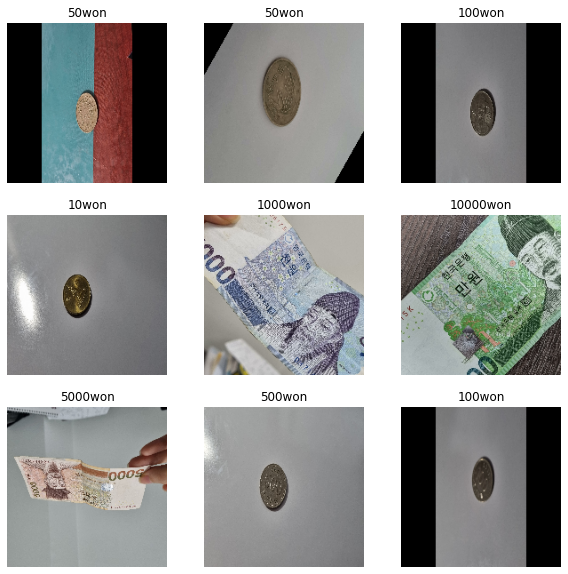

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model 생성

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99894166


In [17]:
num_classes = 8

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [20]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 335s 5s/step - loss: 1.5747 - accuracy: 0.3743 - val_loss: 1.2063 - val_accuracy: 0.4732
Epoch 2/10
54/54 [==============================] - 3s 47ms/step - loss: 0.8255 - accuracy: 0.6682 - val_loss: 0.7426 - val_accuracy: 0.7226
Epoch 3/10
54/54 [==============================] - 2s 44ms/step - loss: 0.5331 - accuracy: 0.7887 - val_loss: 0.8300 - val_accuracy: 0.6410
Epoch 4/10
54/54 [==============================] - 2s 45ms/step - loss: 0.3754 - accuracy: 0.8498 - val_loss: 0.4230 - val_accuracy: 0.8112
Epoch 5/10
54/54 [==============================] - 2s 45ms/step - loss: 0.2394 - accuracy: 0.9075 - val_loss: 0.4780 - val_accuracy: 0.8182
Epoch 6/10
54/54 [==============================] - 2s 45ms/step - loss: 0.2894 - accuracy: 0.8842 - val_loss: 0.6085 - val_accuracy: 0.7739
Epoch 7/10
54/54 [==============================] - 2s 45ms/step - loss: 0.2258 - accuracy: 0.9115 - val_loss: 0.3658 - val_accuracy: 0.8438
Epoch 8/10
54

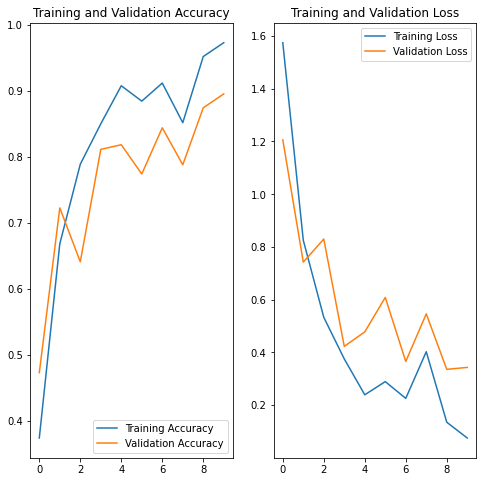

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()